# Effect of percipitation on Accident

Right now problems:  
1. I haven't found expected increase of proportion of rainy days with severity's increase.
2. Haven't found any similar patterns between Major cities' and other cities' or any apprent patterns seperately.
4. All correlations are quite close to 0.(No matter using pierse correlation or kendall correlation.)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
%matplotlib inline

In [2]:
records=pd.read_csv('random_sample_data_MQ.csv',iterator=True,chunksize=10**5,low_memory=False)

In [3]:
mylist=[]
for chunk in records:
    mylist.append(chunk[['Type','Severity','StartTime(UTC)','LocalTimeZone','City','Precipitation(in)','WeatherSeverity']])
records=pd.concat(mylist)
records['StartTime(UTC)']=pd.to_datetime(records['StartTime(UTC)'])


In [4]:
records=records[records['LocalTimeZone'].notnull()]

In [5]:
dic={'EDT':datetime.timedelta(hours=-4), 'EST':datetime.timedelta(hours=-5),
     'CDT':datetime.timedelta(hours=-5), 'CST':datetime.timedelta(hours=-6), 
     'MDT':datetime.timedelta(hours=-6), 'MST':datetime.timedelta(hours=-7),
     'PDT':datetime.timedelta(hours=-7), 'PST':datetime.timedelta(hours=-8)}
records['StartTime(UTC)']=records['StartTime(UTC)']+records['LocalTimeZone'].map(lambda x:dic[x])

In [6]:
# clean data based on time
# end=datetime.datetime(2018,2,1)
start=datetime.datetime(2016,2,1)
records=records[(records['StartTime(UTC)']>=start)]

## Effect of precipitation

### effect of precipitation for all types

In [7]:
def distribution(df,ax,title):
    value=df.groupby('Severity')['Precipitation(in)'].apply(lambda a:len(a[a>0])/len(a))
    ax.bar(range(5),[value[i] if i in value else 0 for i in range(5)],tick_label=range(5))
    ax.set_title(title, fontdict={'fontsize': 16, 'fontweight': 'bold'})

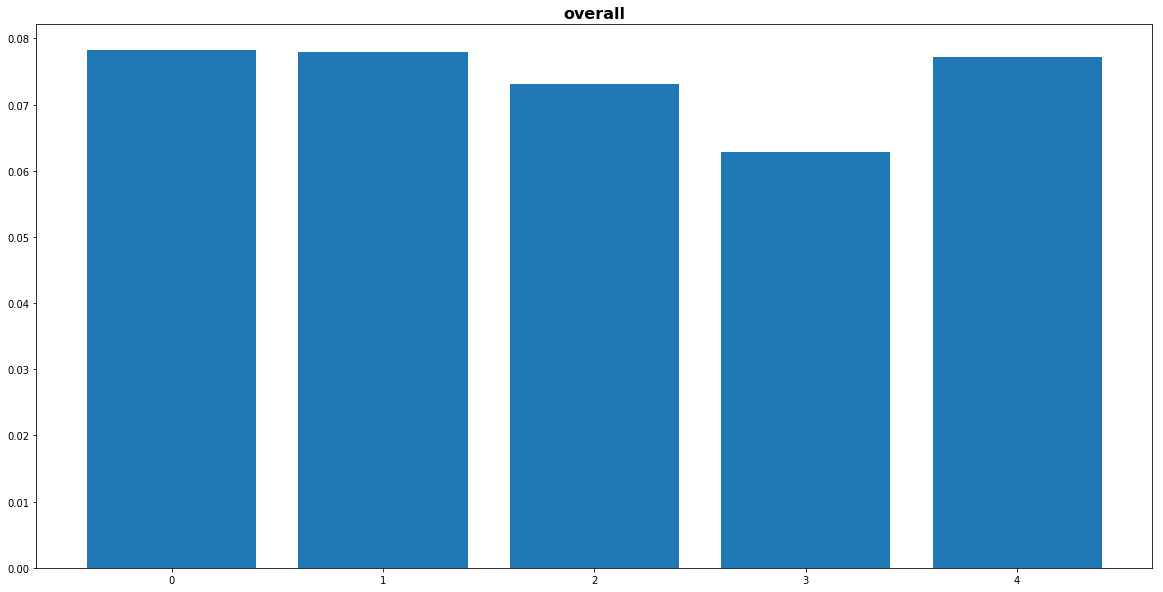

In [8]:
fg, ax = plt.subplots(1, 1, figsize=(20, 10))
distribution(records,ax,'overall')

### effect of precipitation on a certain type

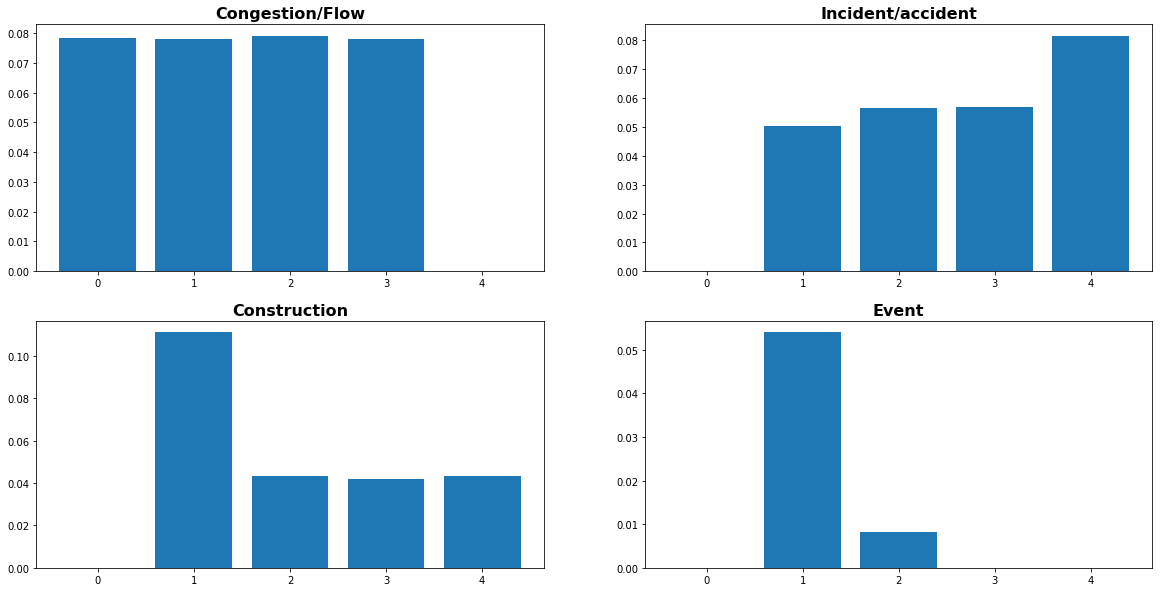

In [9]:
fg,axes=plt.subplots(2, 2, figsize=(20, 10))
kinds=records.Type.unique()
k=0
for i in range(2):
    for j in range(2):
        distribution(records[records['Type']==kinds[k]],axes[i][j],kinds[k])
        k+=1

### Major cities and other cities

In [10]:
cities=records['City'].value_counts()[:10].index
cities

Index(['Los Angeles', 'Houston', 'Miami', 'New York', 'Atlanta', 'Chicago',
       'Dallas', 'Austin', 'Brooklyn', 'Seattle'],
      dtype='object')

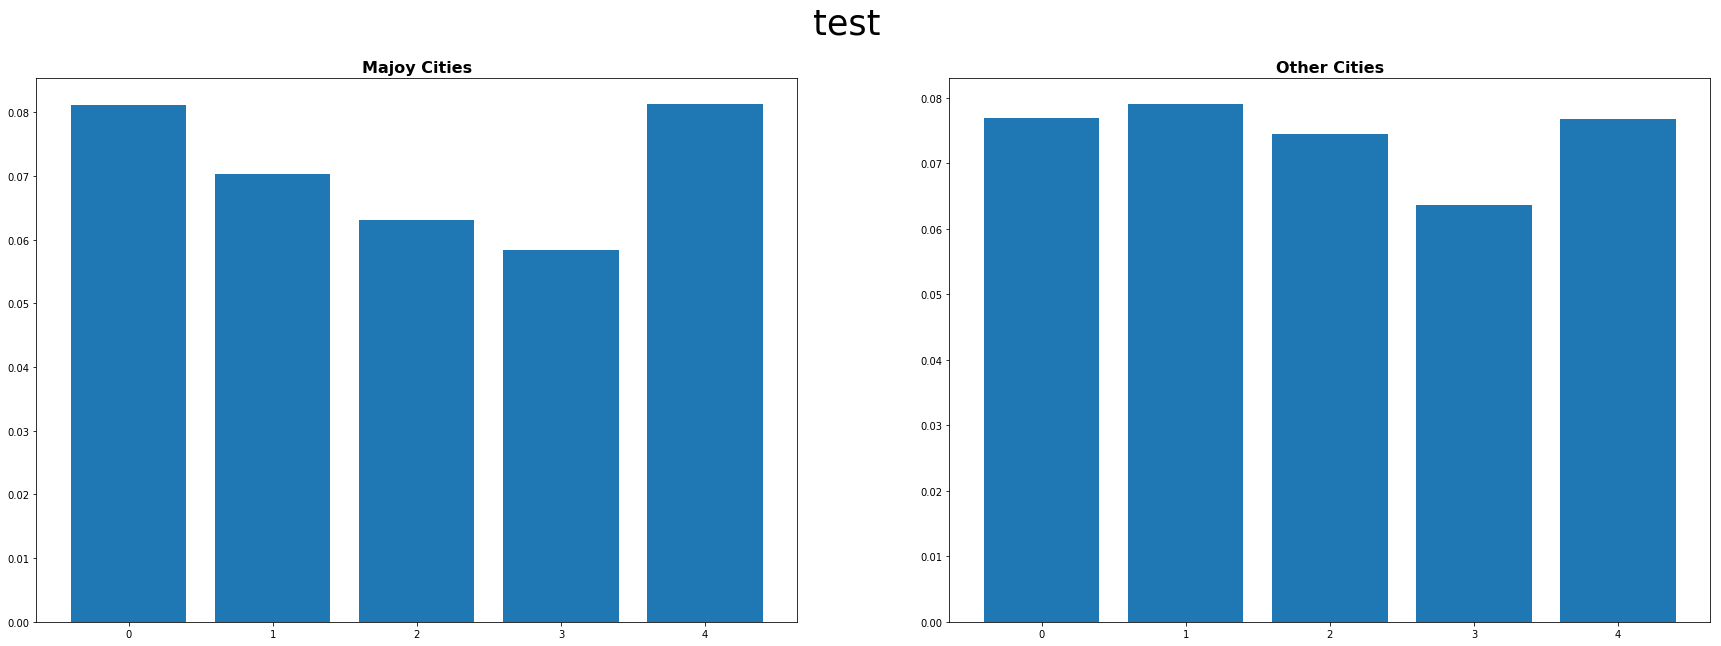

In [11]:

fg, axes = plt.subplots(1, 2, figsize=(30, 10))
plt.suptitle('test',fontsize=35)
major_cities=records.loc[records['City'].isin(cities)]
other_cities=records.loc[records['City'].isin(cities)==False]
distribution(major_cities,axes[0],'Majoy Cities')
distribution(other_cities,axes[1],'Other Cities')


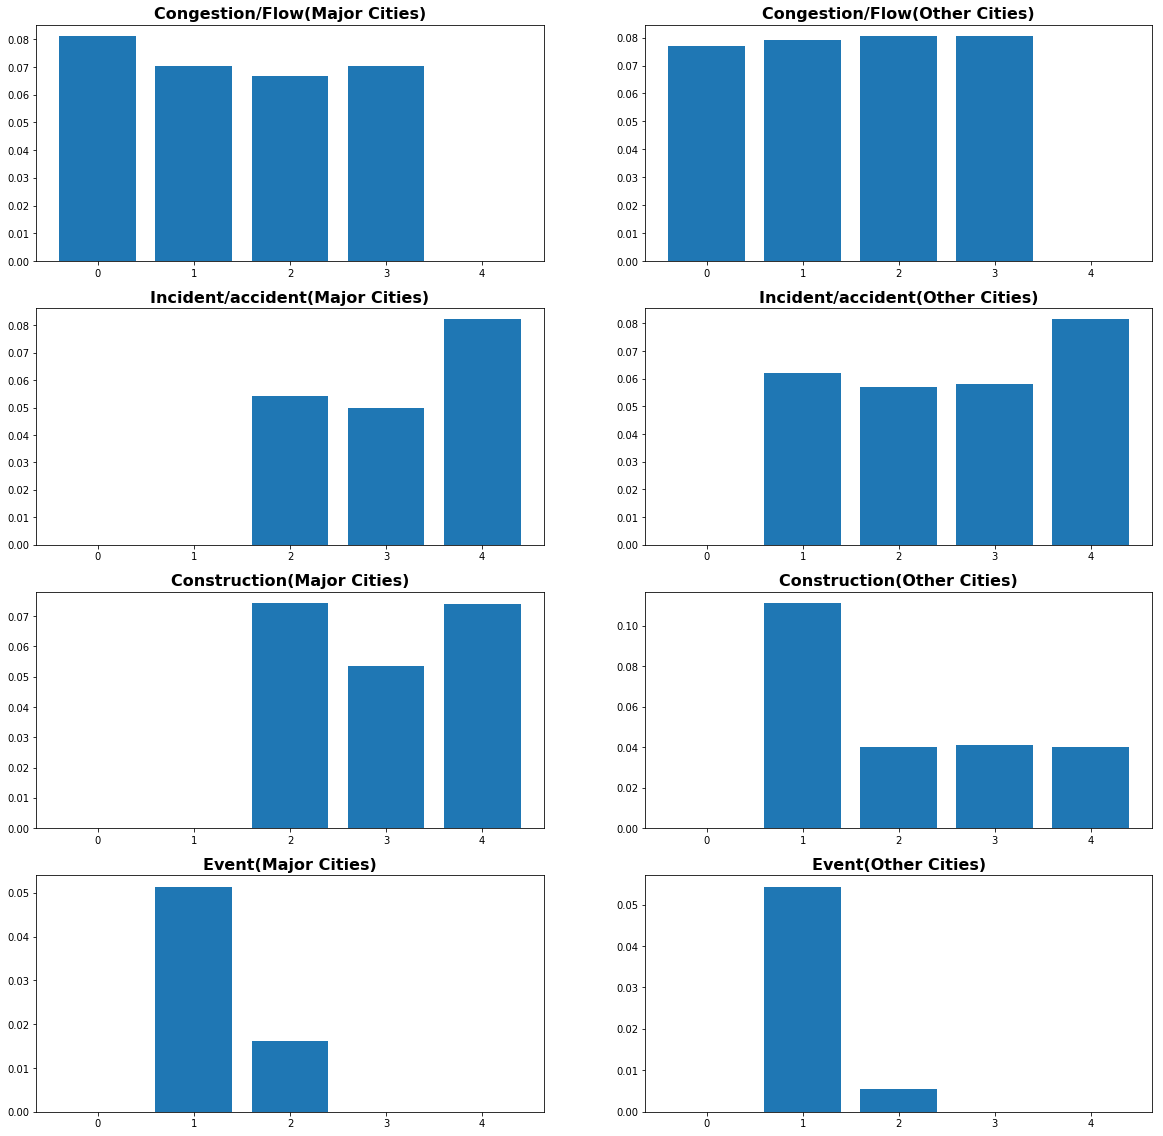

In [12]:
fg, axes = plt.subplots(4, 2, figsize=(20, 20))

for i in range(len(kinds)):
    distribution(major_cities[major_cities['Type']==kinds[i]],axes[i][0],kinds[i]+"(Major Cities)")
for i in range(len(kinds)):
    distribution(other_cities[other_cities['Type']==kinds[i]],axes[i][1],kinds[i]+"(Other Cities)")

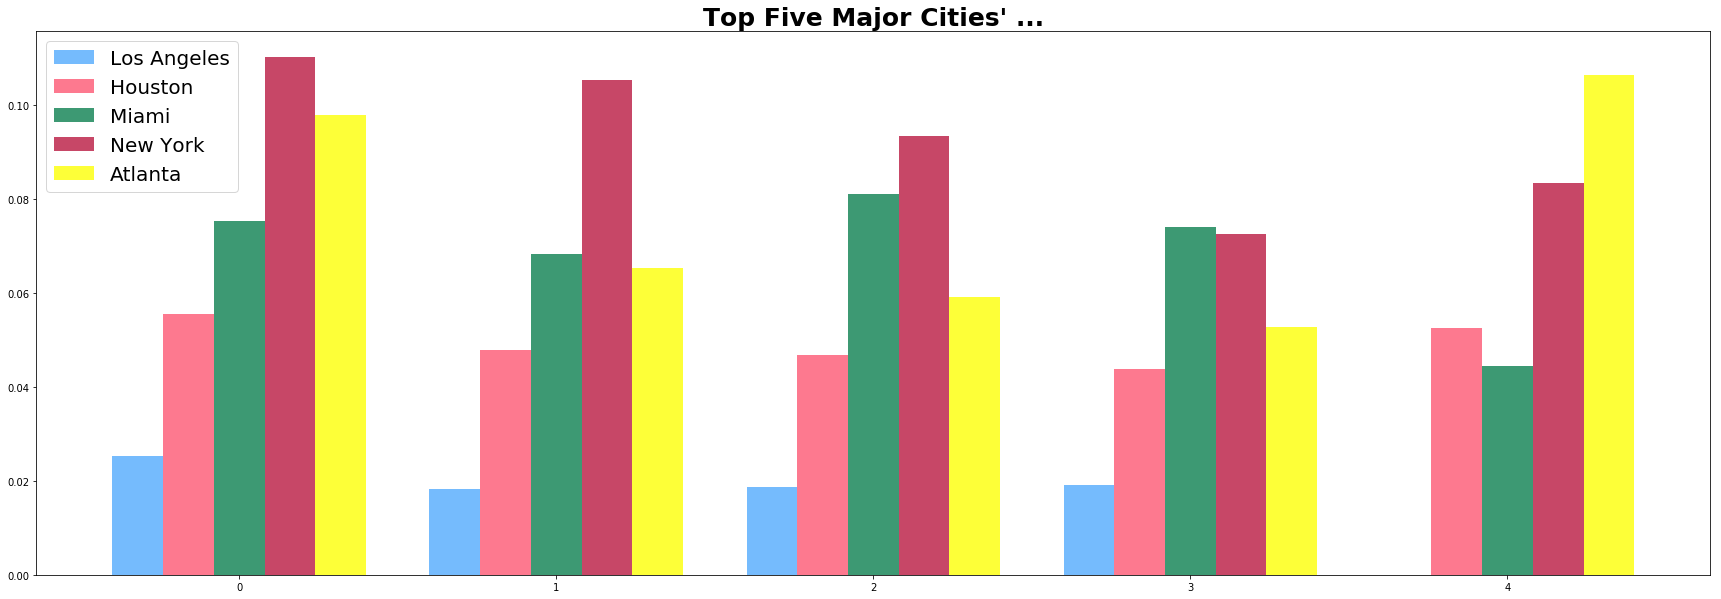

In [13]:
top_five=cities[:5]
plt.figure(figsize=(30,10))

x =list(range(5))  
total_width, n = 0.8, 5  
width = total_width / n  
cl=['lemon yellow','deep rose','ocean green','carnation','sky blue']
for city in top_five:
    target=records[records['City']==city]
    value = target.groupby('Severity')['Precipitation(in)'].apply(lambda a:len(a[a>0])/len(a))
    plt.bar(x, [value[i] if i in value else 0 for i in range(5)], width=width, label=city,fc ='xkcd:'+cl.pop())
    for i in range(len(x)):
        x[i]+=width
plt.xticks([i+2*width for i in range(5)],range(5))
plt.legend(prop = {'size':20})
plt.title("Top Five Major Cities\' ...", fontdict={'fontsize': 25, 'fontweight': 'bold'})
pass

To find the reason for the loss of value for major cities. We need to check the distribution of severity.

In [14]:
def severity_distribution(part, ax, title):
    groupby = part.groupby('Severity')['Severity'].count()
    labels= groupby.keys()
    values = groupby.values
    ax.axis('equal')
    ax.pie(values, labels=labels)
    ax.set_title(title, fontdict={'fontsize': 16, 'fontweight': 'bold'})

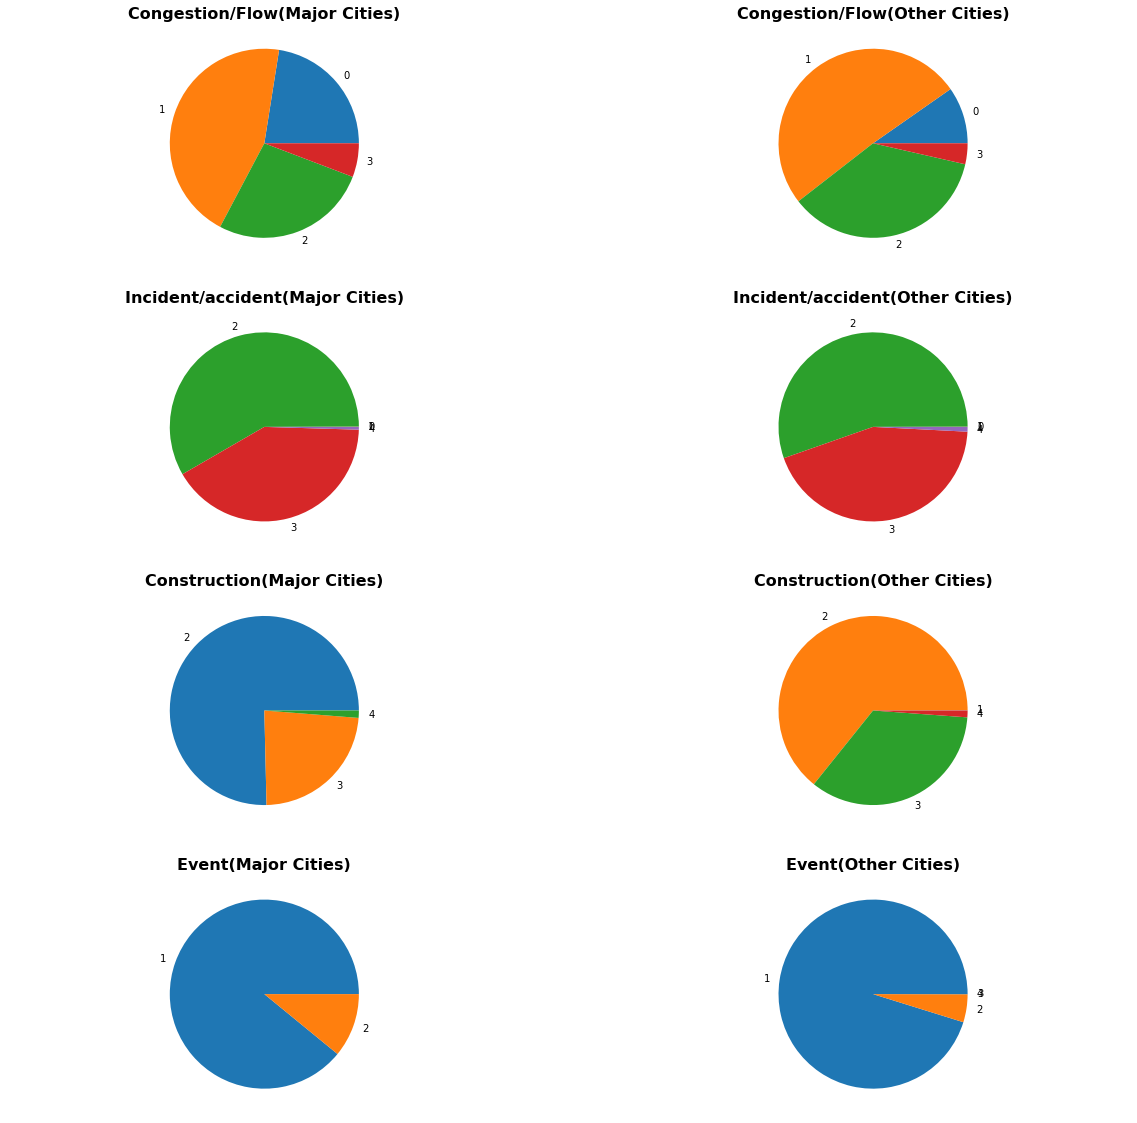

In [15]:
fg, axes = plt.subplots(4, 2, figsize=(20, 20))

for i in range(len(kinds)):
    severity_distribution(major_cities[major_cities['Type']==kinds[i]],axes[i][0],kinds[i]+"(Major Cities)")
for i in range(len(kinds)):
    severity_distribution(other_cities[other_cities['Type']==kinds[i]],axes[i][1],kinds[i]+"(Other Cities)")

## the correlation between severity of traffic incident and weather precipitation

In [16]:
records['WeatherSeverity'].unique()

array([nan, 'light', 'moderate', 'heavy'], dtype=object)

In [17]:
temp=records['WeatherSeverity'].copy()

temp[temp.isnull()]=0

dic={0:0,'light':1,'moderate':2,'heavy':3}
temp=temp.map(lambda x:dic[x])

temp=pd.concat([temp,records['Severity']],axis=1)

temp.corr('kendall')

,WeatherSeverity,Severity
WeatherSeverity,1.000000,-0.017153
Severity,-0.017153,1.000000


In [18]:
def correlation(df):
    temp=df['WeatherSeverity'].copy()
    temp[temp.isnull()]=0
    dic={0:0,'light':1,'moderate':2,'heavy':3}
    temp=temp.map(lambda x:dic[x])
    temp=pd.concat([temp,records['Severity']],axis=1)
    return temp.corr().iloc[0,1]

In [19]:
correlation(records)

-0.018674203167146314

In [20]:
correlation(major_cities)

-0.026088373227703958

In [21]:
correlation(other_cities)

-0.019562644120997424

In [22]:
mylist=[]
for i in range(len(kinds)):
    mylist.append(correlation(records[records['Type']==kinds[i]]))
pd.Series(mylist,index=kinds)

Congestion/Flow      0.005945
Incident/accident    0.004153
Construction         0.006012
Event               -0.049895
dtype: float64

In [23]:
mylist=[]
for i in range(len(kinds)):
    mylist.append(correlation(major_cities[major_cities['Type']==kinds[i]]))
pd.Series(mylist,index=kinds)

Congestion/Flow     -0.013168
Incident/accident    0.001040
Construction        -0.013831
Event               -0.052908
dtype: float64

In [24]:
mylist=[]
for i in range(len(kinds)):
    mylist.append(correlation(other_cities[other_cities['Type']==kinds[i]]))
pd.Series(mylist,index=kinds)

Congestion/Flow      0.006670
Incident/accident    0.004271
Construction         0.007797
Event               -0.047495
dtype: float64